In [31]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import cv2
from ultralytics import YOLO
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Optional

In [32]:

class ImageState(TypedDict):
    image_path: str
    is_diagram: Optional[bool]
    classification_confidence: Optional[float]
    diagram_detections: Optional[list]
    verbose: bool

In [33]:
def read_image(state: ImageState):
    if state["verbose"]:
        print(f"🔍 Reading image: {state['image_path']}")
    return {}

In [34]:
def classify_image(state: ImageState):
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    
    image = Image.open(state["image_path"]).convert("RGB")
    inputs = processor(text=["a diagram", "not a diagram"], images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1)
    
    is_diagram = probs.argmax() == 0
    return {"is_diagram": is_diagram, "classification_confidence": probs.max().item()}

In [35]:
def handle_non_diagram(state: ImageState):
    print("🚫 Not a diagram. Ending pipeline.")
    return {}

In [36]:
def route_decision(state: ImageState) -> str:
    return "run_yolo_detection" if state["is_diagram"] else "handle_non_diagram"

In [37]:
from src.yolo.detect import run_custom_yolo  # Import your helper function

def run_yolo_detection(state: ImageState):
    if state["verbose"]:
        print("📦 Running custom YOLO model...")
    detections = run_custom_yolo(state["image_path"])
    
    if state["verbose"]:
        for det in detections:
            print(f"Detected: {det['label']} at {det['coords']} (confidence: {det['confidence']:.2f})")

    return {"diagram_detections": detections}

In [38]:
graph = StateGraph(ImageState)
graph.add_node("read_image", read_image)
graph.add_node("classify_image", classify_image)
graph.add_node("handle_non_diagram", handle_non_diagram)
graph.add_node("run_yolo_detection", run_yolo_detection)

graph.add_edge(START, "read_image")
graph.add_edge("read_image", "classify_image")
graph.add_conditional_edges("classify_image", route_decision, {
    "run_yolo_detection": "run_yolo_detection",
    "handle_non_diagram": "handle_non_diagram"
})

graph.add_edge("run_yolo_detection", END)
graph.add_edge("handle_non_diagram", END)

compiled_graph = graph.compile()

In [39]:


#Visualization Helper of bounding boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_boxes(image_path, detections):
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image)

    for det in detections:
        x1, y1, x2, y2 = det["coords"]
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{det['label']} ({det['confidence']:.2f})", color='white', backgroundcolor='red')

    plt.axis("off")
    plt.show()

🔍 Reading image: datasets/test/images/3.png
📦 Running custom YOLO model...

image 1/1 /Users/emilstausbol/Documents/GitHub/AIML25-Exam/datasets/test/images/3.png: 224x640 8 sub-flows, 1337.8ms
Speed: 12.2ms preprocess, 1337.8ms inference, 11.0ms postprocess per image at shape (1, 3, 224, 640)
Detected: sub-flow at [1360.596923828125, 226.4014892578125, 1992.7215576171875, 576.7591552734375] (confidence: 1.00)
Detected: sub-flow at [18.201372146606445, 220.64479064941406, 445.4991760253906, 570.8748779296875] (confidence: 0.99)
Detected: sub-flow at [467.07525634765625, 226.03504943847656, 1059.14404296875, 567.8630981445312] (confidence: 0.99)
Detected: sub-flow at [32.3548469543457, 46.62974166870117, 1091.6063232421875, 423.71533203125] (confidence: 0.75)
Detected: sub-flow at [738.7013549804688, 57.76424026489258, 1791.8956298828125, 488.1050109863281] (confidence: 0.74)
Detected: sub-flow at [703.8070068359375, 62.257591247558594, 1795.435791015625, 355.8941345214844] (confidence: 

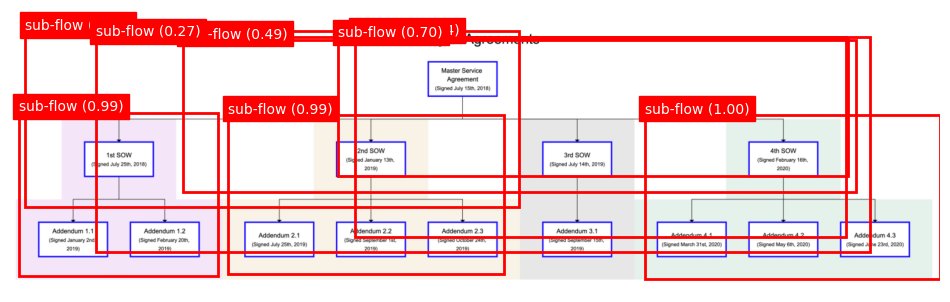

In [48]:
# Define once here — used everywhere
image_path = "datasets/test/images/3.png"

# Run the agent
result = compiled_graph.invoke({
    "image_path": image_path,
    "verbose": True
})

# Conditionally show results
if result.get("is_diagram") and "diagram_detections" in result:
    show_image_with_boxes(image_path, result["diagram_detections"])
else:
    print("❌ This image was not classified as a diagram. No detection results to show.")